In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = torch.load('../../pre_calculated_logits/cifar10_resnet50.pt')
# data = torch.load('../../pre_calculated_logits/imagenet_vit_b_16.pt')
# data = torch.load('../../pre_calculated_logits/imagenet_efficientnet_b0.pt')
load_features = data['features_val']
labels = data['labels_val']
logits = data['logits_val']
load_features.shape, labels.shape, logits.shape

(torch.Size([5000, 2048]), torch.Size([5000]), torch.Size([5000, 10]))

In [3]:
# get wrongly prediction index with the confidence larger than 0.95
wrong_index = torch.where((labels != logits.argmax(dim=1)) & (F.softmax(logits, dim=1).max(dim=1).values > 0.8))[0]
# get correct prediction index with the confidence larger than 0.95
correct_index = torch.where((labels == logits.argmax(dim=1)) & (F.softmax(logits, dim=1).max(dim=1).values > 0.8))[0]
len(wrong_index), len(correct_index)

(196, 4740)

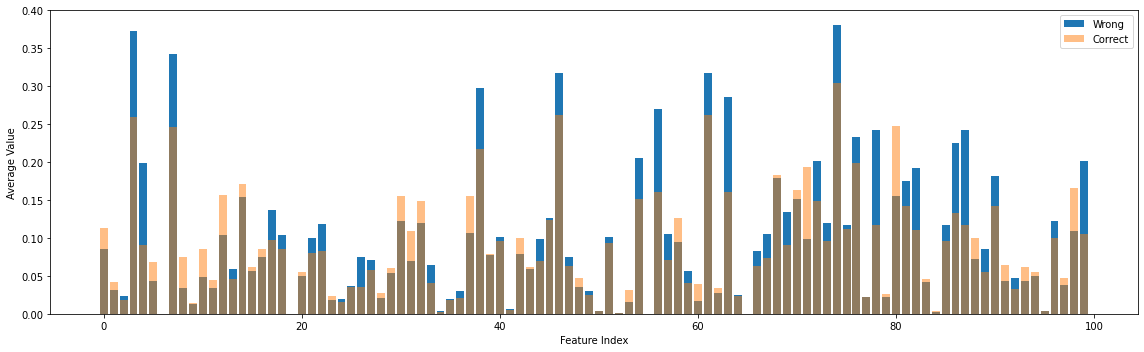

In [4]:
# randomly select 100 units from the feature
selected_units = np.random.choice(load_features.shape[1], 100, replace=True)
features = load_features[:,selected_units]
# plot all features of worngly predicted samples using bar char, x-axis is each unit of features, y-axis is the average value of each unit
plt.figure(figsize=(16, 5))
plt.bar(np.arange(features.shape[1]), features[wrong_index].mean(dim=0).cpu())
# plot all features of correctly predicted samples using bar char, x-axis is each unit of features, y-axis is the average value of each unit in one figure
plt.bar(np.arange(features.shape[1]), features[correct_index].mean(dim=0).cpu(), alpha=0.5)
plt.xlabel('Feature Index')
plt.ylabel('Average Value')
# plt.title('Feature Distribution')
plt.legend(['Wrong', 'Correct'])
plt.tight_layout()
plt.savefig('feature_distribution.pdf')
plt.show()


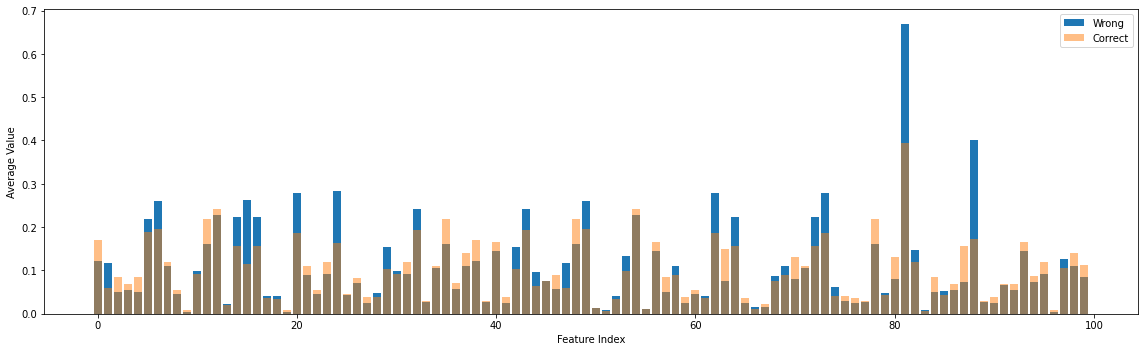

In [5]:
# randomly select 100 units from the feature
selected_units = np.random.choice(features.shape[1], 100, replace=True)
features = load_features[:,selected_units]
# plot all features of worngly predicted samples using bar char, x-axis is each unit of features, y-axis is the average value of each unit
plt.figure(figsize=(16, 5))
plt.bar(np.arange(features.shape[1]), torch.abs(features[wrong_index]).mean(dim=0).cpu())
# plot all features of correctly predicted samples using bar char, x-axis is each unit of features, y-axis is the average value of each unit in one figure
plt.bar(np.arange(features.shape[1]), torch.abs(features[correct_index]).mean(dim=0).cpu(), alpha=0.5)
plt.xlabel('Feature Index')
plt.ylabel('Average Value')
# plt.title('Feature Distribution')
plt.legend(['Wrong', 'Correct'])
plt.tight_layout()
plt.savefig('feature_distribution.pdf')
plt.show()


In [16]:
# plot the histogram of feature value of all units, except values largers than 0.4
plt.figure(figsize=(16, 5))
plt.hist(features[wrong_index].flatten().cpu().numpy(), bins=10000, range=(0.0, 0.1), alpha=0.5, label='Wrong')
plt.hist(features[correct_index][:len(wrong_index)].flatten().cpu().numpy(), bins=10000, range=(0.0, 0.1), alpha=0.5, label='Correct')
# draw an vertical line that represents the threshold of 95% quantile of the correct feature value
# plt.axvline(0.23, color='r')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()